# DEJMPS Protocol

In [1]:
#imports
from qutip import *
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import Gate, cnot
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from qutip.qip.operations.gates import (rx, ry, rz)
import random
from qutip.measurement import measure



In [2]:
#FUNCTION TO CHECK IF A STATE IS A WERNER STATE

def check_werner_r1(rho, tol=1e-6):
    """
    Check whether a 4x4 matrix rho corresponds to the Werner-type state:
    rho_W = r1 * |1><1| + (1-r1)/3 * (I4 - |1><1|)
    where |1> = (|01> - |10>)/sqrt(2).
    In the computational basis {|00>, |01>, |10>, |11>}, the matrix form is:
    rho_W = [[(1-r1)/3, 0, 0, 0],
    [0, (2*r1+1)/6, (1-4*r1)/6, 0],
    [0, (1-4*r1)/6, (2*r1+1)/6, 0],
    [0, 0, 0, (1-r1)/3]]
    Parameters
    ----------
    rho : 2D numpy array (shape (4,4))
    The density matrix to test.
    tol : float
    Numerical tolerance for consistency checks.
    Returns
    -------
    (is_werner, r1_value)
    is_werner : bool
    True if all derived r1 values match within 'tol'.
    r1_value : float or None
    The average r1 if consistent, else None.
    """

    # Corner diagonals (should be (1-r1)/3):

    corner_val = rho[0, 0] # same as rho[3,3] ideally

    # Center diagonals (should be (2*r1 + 1)/6):

    center_diag_val = rho[1, 1] # same as rho[2,2] ideally

    # Off-diagonals in the center block (should be (1 - 4*r1)/6):

    center_offdiag_val = rho[1, 2] # same as rho[2,1] ideally

    # Solve for r1 from each expression:

    # 1) corner_val = (1 - r1)/3 => r1 = 1 - 3 * corner_val

    r1_corner = 1.0 - 3.0 * corner_val

    # 2) center_diag_val = (2*r1 + 1)/6 => 2*r1 + 1 = 6*center_diag_val => r1 = 3*center_diag_val - 0.5

    r1_center_diag = 3.0 * center_diag_val - 0.5

    # 3) center_offdiag_val = (1 - 4*r1)/6 => 1 - 4*r1 = 6*center_offdiag_val => r1 = (1 - 6*center_offdiag_val)/4

    r1_center_offdiag = (1.0 - 6.0 * center_offdiag_val) / 4.0

    # Put them all in a list

    r1_candidates = [r1_corner, r1_center_diag, r1_center_offdiag]

    # Check if they are all close within 'tol'
    if (np.allclose(r1_corner, r1_center_diag, atol=tol) and np.allclose(r1_corner, r1_center_offdiag, atol=tol)):

        # If consistent, return average

        r1_mean = np.mean(r1_candidates)
        return True, r1_mean
    else:
    # Not consistent -> not a Werner state of this specific form
        return False, None



In [3]:
phi_plus = bell_state("00")
phi_minus = bell_state("01")
psi_plus = bell_state("10")
psi_minus = bell_state("11")

def bds_state(p):
    p1 = p
    p2 = (1-p1)/2
    p3 = (1-p1)/3
    p4 = (1-p1)/6

    state = p1 * (phi_plus * phi_plus.dag()) + p2 * (psi_plus * psi_plus.dag()) + p3 * phi_minus * phi_minus.dag() + p4 * psi_minus * psi_minus.dag()
    return state

bds_state = bds_state(0.7)
print(bds_state)
print(fidelity(bds_state, bell_state("00")))

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.4  0.   0.   0.3 ]
 [0.   0.1  0.05 0.  ]
 [0.   0.05 0.1  0.  ]
 [0.3  0.   0.   0.4 ]]
0.8366600265340758


succesful purification result
Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.375  0.     0.     0.2275]
 [0.     0.125  0.0175 0.    ]
 [0.     0.0175 0.125  0.    ]
 [0.2275 0.     0.     0.375 ]]
0.7762087422635823


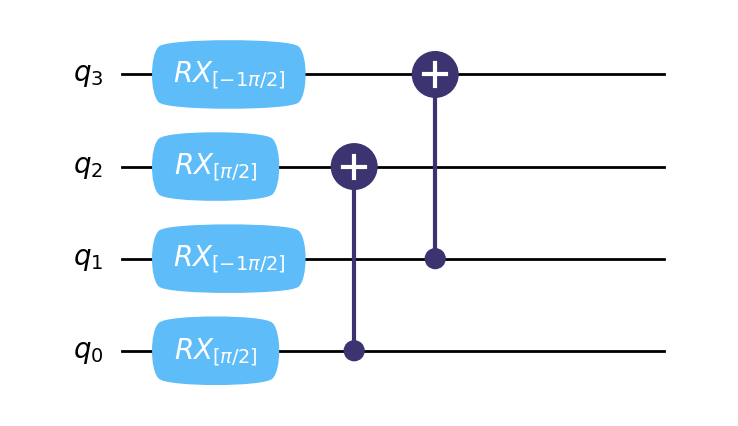

In [7]:
purification_circuit = QubitCircuit(N = 4)
purification_circuit.add_gate("RX", targets = [0], arg_value= pi/2, style={"showarg": True})
purification_circuit.add_gate("RX", targets = [1], arg_value= -pi/2, style={"showarg": True})
purification_circuit.add_gate("RX", targets = [2], arg_value= pi/2, style={"showarg": True})
purification_circuit.add_gate("RX", targets = [3], arg_value= -pi/2, style={"showarg": True})
purification_circuit.add_gate("CNOT", targets = [2], controls=[0])
purification_circuit.add_gate("CNOT", targets = [3], controls=[1])

purification_result = purification_circuit.run(state = tensor(bds_state, bds_state))
# print(purification_result)
Z0, Z1 = ket2dm(basis(2, 0)), ket2dm(basis(2, 1))
PZ1 = [tensor(identity(2), identity(2), Z0, Z0), tensor(identity(2), identity(2), Z1, Z1), tensor(identity(2), identity(2), Z0, Z1), tensor(identity(2), identity(2), Z1, Z0)]
measurement_result = measure(purification_result,PZ1)
# print(measurement_result[1])

if measurement_result[0] == 0 or measurement_result[0] == 1:
    print("succesful purification result")
    # post_purification_state = purification_result.ptrace([0,1])
    print(purification_result.ptrace([0,1]))
    print(fidelity(purification_result.ptrace([0,1]),bell_state("00")))


purification_circuit.draw("matplotlib", dpi=200)